In [ ]:
!pip install -q kaggle

In [ ]:

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kavanabm","key":"32d6c6e18ddaf2ec3e094108b64c435c"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d osamajalilhassan/bone-fracture-dataset


Dataset URL: https://www.kaggle.com/datasets/osamajalilhassan/bone-fracture-dataset
License(s): unknown
 68% 117M/173M [00:00<00:00, 1.22GB/s]
100% 173M/173M [00:00<00:00, 1.01GB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/bone-fracture-dataset.zip')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import vgg16
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix, fbeta_score
import seaborn as sns
import cv2
import pandas as pd
import time

In [ ]:
DATADIR ='/content/BoneFractureDataset'
CATEGORIES = ['fractured','not_fractured']

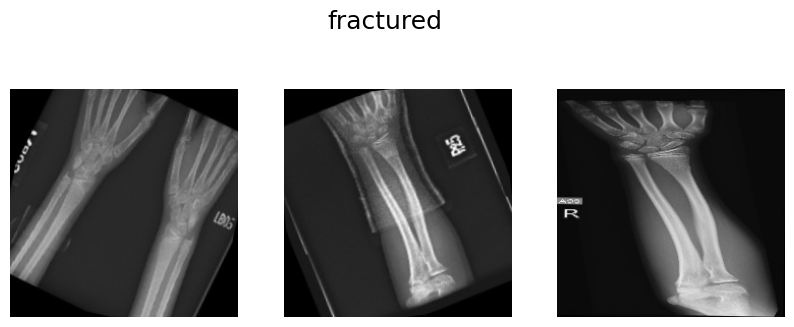

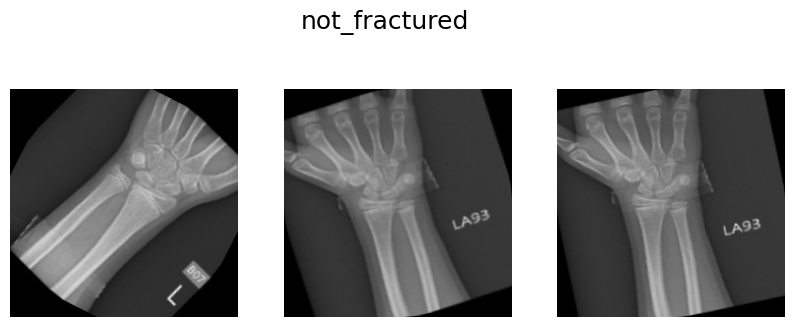

In [ ]:

for category in CATEGORIES:
    path = os.path.join(DATADIR, 'testing', category)  # or 'training' if you want to visualize training images
    images = os.listdir(path)
    fig, ax = plt.subplots(1, 3, figsize=(10, 4))
    fig.suptitle(f'{category}', fontsize=18)

    for i in range(3):
        img_name = images[np.random.randint(0, len(images))]
        img_path = os.path.join(path, img_name)
        img_array = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
        ax[i].imshow(img_rgb)
        ax[i].axis('off')

    plt.show()

In [ ]:
import os
import cv2

# Set the dataset directory and categories
DATADIR = '/content/BoneFractureDataset/training'  # Use training directory
CATEGORIES = ['fractured', 'not_fractured']
IMG_SIZE = 224 # Set your desired image size (e.g., 100x100)

training_data = []

def create_training_data():
    for category in CATEGORIES:
        path = os.path.join(DATADIR, category)  # Include the category folder (fractured/not_fractured)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img))
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # Resize image
                training_data.append([new_array, class_num])  # Append resized image and class number
            except Exception as e:
                pass  # In case of errors, just skip the image

create_training_data()
print(f"✅ Training samples: {len(training_data)}")


✅ Training samples: 8863


In [ ]:

X = []
y = []

for features, label in training_data:
    X.append(features)
    y.append(label)

# Convert lists to NumPy arrays
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
y = np.array(y)



In [ ]:

from sklearn.model_selection import train_test_split

# Split training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f'✅ X_train shape: {X_train.shape}')
print(f'✅ X_val shape:   {X_val.shape}')



✅ X_train shape: (7090, 224, 224, 3)
✅ X_val shape:   (1773, 224, 224, 3)


In [ ]:
# Define test data directory
TESTDIR = '/content/BoneFractureDataset/testing'

# Initialize test data list
test_data = []

def create_test_data():
    for category in CATEGORIES:
        path = os.path.join(TESTDIR, category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img))
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                test_data.append([new_array, class_num])
            except Exception as e:
                pass

# Create the test data
create_test_data()

# Split features and labels
X_test = []
y_test = []

for features, label in test_data:
    X_test.append(features)
    y_test.append(label)

# Convert to numpy arrays
X_test = np.array(X_test).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
y_test = np.array(y_test)

# Normalize pixel values
X_test = X_test / 255.0

# Show shape
print(f'✅ X_test shape: {X_test.shape}')
print(f'✅ y_test shape: {y_test.shape}')


✅ X_test shape: (600, 224, 224, 3)
✅ y_test shape: (600,)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Dense, Flatten,
    Dropout, BatchNormalization, Activation, GlobalAveragePooling2D
)
from tensorflow.keras.optimizers import Adam


custom_model = Sequential()

# ====== Block 1 ======
custom_model.add(Conv2D(32, (3, 3), padding='same', input_shape=(224, 224, 3)))
custom_model.add(BatchNormalization())
custom_model.add(Activation('relu'))

custom_model.add(Conv2D(32, (3, 3), padding='same'))
custom_model.add(BatchNormalization())
custom_model.add(Activation('relu'))

custom_model.add(MaxPooling2D(pool_size=(2, 2)))
custom_model.add(Dropout(0.25))

# ====== Block 2 ======
custom_model.add(Conv2D(64, (3, 3), padding='same'))
custom_model.add(BatchNormalization())
custom_model.add(Activation('relu'))

custom_model.add(Conv2D(64, (3, 3), padding='same'))
custom_model.add(BatchNormalization())
custom_model.add(Activation('relu'))

custom_model.add(MaxPooling2D(pool_size=(2, 2)))
custom_model.add(Dropout(0.3))

# ====== Block 3 ======
custom_model.add(Conv2D(128, (3, 3), padding='same'))
custom_model.add(BatchNormalization())
custom_model.add(Activation('relu'))

custom_model.add(Conv2D(128, (3, 3), padding='same'))
custom_model.add(BatchNormalization())
custom_model.add(Activation('relu'))

custom_model.add(MaxPooling2D(pool_size=(2, 2)))
custom_model.add(Dropout(0.4))

# ====== Block 4 ======
custom_model.add(Conv2D(256, (3, 3), padding='same'))
custom_model.add(BatchNormalization())
custom_model.add(Activation('relu'))

custom_model.add(Conv2D(256, (3, 3), padding='same'))
custom_model.add(BatchNormalization())
custom_model.add(Activation('relu'))

custom_model.add(MaxPooling2D(pool_size=(2, 2)))
custom_model.add(Dropout(0.4))

# ====== Final Layers ======
custom_model.add(GlobalAveragePooling2D())
custom_model.add(Dense(512, activation='relu'))
custom_model.add(Dropout(0.5))
custom_model.add(Dense(1, activation='sigmoid'))


# Compile the model
custom_model.compile(optimizer=Adam(learning_rate=0.0001),
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

custom_model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 56, 56, 128)    │             

 Total params: 1,308,193 (4.99 MB)

 Trainable params: 1,306,273 (4.98 MB)

 Non-trainable params: 1,920 (7.50 KB)

Epoch 1/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 78s 236ms/step - accuracy: 0.5555 - loss: 0.7011 - val_accuracy: 0.5054 - val_loss: 0.7000
Epoch 2/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 35s 156ms/step - accuracy: 0.7049 - loss: 0.5676 - val_accuracy: 0.5279 - val_loss: 0.7104
Epoch 3/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 41s 156ms/step - accuracy: 0.7664 - loss: 0.4858 - val_accuracy: 0.6103 - val_loss: 0.7761
Epoch 4/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 41s 156ms/step - accuracy: 0.7920 - loss: 0.4396 - val_accuracy: 0.7620 - val_loss: 0.5026
Epoch 5/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 35s 157ms/step - accuracy: 0.8460 - loss: 0.3592 - val_accuracy: 0.7953 - val_loss: 0.4495
Epoch 6/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 41s 156ms/step - accuracy: 0.8715 - loss: 0.2952 - val_accuracy: 0.8810 - val_loss: 0.2853
Epoch 7/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 41s 155ms/step - accuracy: 0.8938 - loss: 0.2557 - val_accuracy: 0.7789 - val_loss: 0.4170
Epoch 8/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 41s 156ms/step - accuracy: 0.9240 - loss: 0

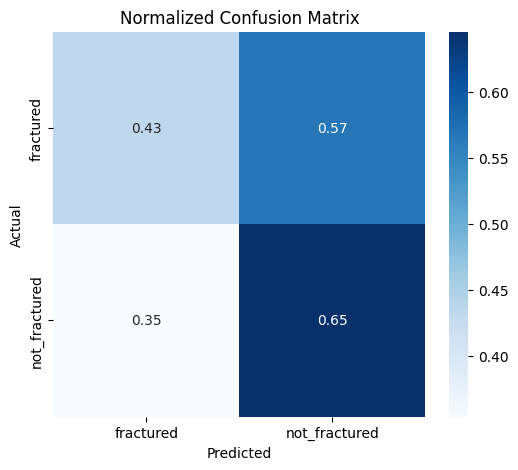


📊 Final MobileNetV2 Summary:

 SL. No.  Sample Size  Train Dataset  Test Dataset        Proposed Model    Input Size  Hidden Layer Size Neurons in Hidden Layers Activation (Hidden)  Neurons (Output Layer) Activation (Output) Optimizer       Loss Function  Epochs  Learning Rate  Execution Time (ms)  Training Accuracy  Validation Accuracy  Testing Accuracy   Loss  Validation Loss  Precision  Recall  F1-score  Classification Miss Rate  Sensitivity  Specificity  F2-score  Fβ-score (β=0.5)  Positive Predicted Value  Negative Predicted Value  False Positive Ratio  False Negative Ratio  Likelihood Positive Ratio  Likelihood Negative Ratio
       2         9463           7090           600 Custom CNN (27-layer) (224, 224, 3)                  4                      512                relu                       1             sigmoid      Adam binary_crossentropy      10         0.0001            442415.91             0.9467               0.8641            0.5183 0.1439           0.3351     0.56

In [ ]:
import os
import cv2
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix, fbeta_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Dense, Flatten,
                                     Dropout, BatchNormalization, Activation, GlobalAveragePooling2D)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input

# ========== STEP 1: Load and preprocess data ==========
DATADIR = "/content/BoneFractureDataset/training"
CATEGORIES = ["fractured", "not_fractured"]
IMG_SIZE = 224

training_data = []
for category in CATEGORIES:
    path = os.path.join(DATADIR, category)
    class_num = CATEGORIES.index(category)
    for img in os.listdir(path):
        try:
            img_array = cv2.imread(os.path.join(path, img))
            new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            training_data.append([new_array, class_num])
        except Exception:
            pass

X = np.array([i[0] for i in training_data]).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
y = np.array([i[1] for i in training_data])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# ========== STEP 2: Define Custom Model ==========
custom_model = Sequential()

# Block 1
custom_model.add(Input(shape=(IMG_SIZE, IMG_SIZE, 3)))
custom_model.add(Conv2D(32, (3, 3), padding='same'))
custom_model.add(BatchNormalization())
custom_model.add(Activation('relu'))
custom_model.add(Conv2D(32, (3, 3), padding='same'))
custom_model.add(BatchNormalization())
custom_model.add(Activation('relu'))
custom_model.add(MaxPooling2D(pool_size=(2, 2)))
custom_model.add(Dropout(0.25))

# Block 2
custom_model.add(Conv2D(64, (3, 3), padding='same'))
custom_model.add(BatchNormalization())
custom_model.add(Activation('relu'))
custom_model.add(Conv2D(64, (3, 3), padding='same'))
custom_model.add(BatchNormalization())
custom_model.add(Activation('relu'))
custom_model.add(MaxPooling2D(pool_size=(2, 2)))
custom_model.add(Dropout(0.3))

# Block 3
custom_model.add(Conv2D(128, (3, 3), padding='same'))
custom_model.add(BatchNormalization())
custom_model.add(Activation('relu'))
custom_model.add(Conv2D(128, (3, 3), padding='same'))
custom_model.add(BatchNormalization())
custom_model.add(Activation('relu'))
custom_model.add(MaxPooling2D(pool_size=(2, 2)))
custom_model.add(Dropout(0.4))

# Block 4
custom_model.add(Conv2D(256, (3, 3), padding='same'))
custom_model.add(BatchNormalization())
custom_model.add(Activation('relu'))
custom_model.add(Conv2D(256, (3, 3), padding='same'))
custom_model.add(BatchNormalization())
custom_model.add(Activation('relu'))
custom_model.add(MaxPooling2D(pool_size=(2, 2)))
custom_model.add(Dropout(0.4))

# Final layers
custom_model.add(GlobalAveragePooling2D())
custom_model.add(Dense(512, activation='relu'))
custom_model.add(Dropout(0.5))
custom_model.add(Dense(1, activation='sigmoid'))

# Compile model
custom_model.compile(optimizer=Adam(learning_rate=0.0001),
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

# ========== STEP 3: Train Model ==========
start_train_time = time.time()
history = custom_model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))
exec_time = (time.time() - start_train_time) * 1000

# ========== STEP 4: Load Test Data ==========
TEST_DIR = "/content/BoneFractureDataset/testing"
test_data = []
for category in CATEGORIES:
    path = os.path.join(TEST_DIR, category)
    class_num = CATEGORIES.index(category)
    for img in os.listdir(path):
        try:
            img_array = cv2.imread(os.path.join(path, img))
            new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            test_data.append([new_array, class_num])
        except Exception:
            pass

X_test = np.array([i[0] for i in test_data])
y_test = np.array([i[1] for i in test_data])

# ========== STEP 5: Evaluate and Generate Report ==========
loss, test_acc = custom_model.evaluate(X_test, y_test)
y_pred_prob = custom_model.predict(X_test).ravel()
predictions = (y_pred_prob > 0.5).astype("int32")

report = classification_report(y_test, predictions, output_dict=True)
cf_matrix = confusion_matrix(y_test, predictions)
cf_norm = confusion_matrix(y_test, predictions, normalize='true')

cf_matrix = confusion_matrix(y_test, predictions)
cf_norm = confusion_matrix(y_test, predictions, normalize='true')

plt.figure(figsize=(6, 5))
sns.heatmap(cf_norm, annot=True, cmap='Blues', xticklabels=CATEGORIES, yticklabels=CATEGORIES)
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ========== STEP 8: Metrics & Summary Table ==========
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
val_loss = history.history['val_loss'][-1]
train_loss = history.history['loss'][-1]

report = classification_report(y_test, predictions, output_dict=True)
precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']
f1 = report['weighted avg']['f1-score']
sensitivity = recall
specificity = np.mean(np.diag(cf_norm))
classification_miss_rate = 1 - test_acc

TP = np.diag(cf_matrix)
FP = np.sum(cf_matrix, axis=0) - TP
FN = np.sum(cf_matrix, axis=1) - TP
TN = np.sum(cf_matrix) - (TP + FP + FN)

PPV = TP / (TP + FP + 1e-10)
NPV = TN / (TN + FN + 1e-10)
FPR = FP / (FP + TN + 1e-10)
FNR = FN / (FN + TP + 1e-10)
LPR = PPV / (1 - FPR + 1e-10)
LNR = FNR / (1 - NPV + 1e-10)

PPV_avg = np.mean(PPV)
NPV_avg = np.mean(NPV)
FPR_avg = np.mean(FPR)
FNR_avg = np.mean(FNR)
LPR_avg = np.mean(LPR)
LNR_avg = np.mean(LNR)

f2 = fbeta_score(y_test, predictions, beta=2, average='weighted')
fbeta_custom = fbeta_score(y_test, predictions, beta=0.5, average='weighted')

# ========== STEP 9: Result Table ==========
result = {
    "SL. No.": 2,
    "Sample Size": len(X) + len(X_test),
    "Train Dataset": len(X_train),
    "Test Dataset": len(X_test),
    "Proposed Model": "Custom CNN (27-layer)",
    "Input Size": X_train.shape[1:4],
    "Hidden Layer Size": 4,
    "Neurons in Hidden Layers": "512",
    "Activation (Hidden)": "relu",
    "Neurons (Output Layer)": 1,
    "Activation (Output)": "sigmoid",
    "Optimizer": "Adam",
    "Loss Function": "binary_crossentropy",
    "Epochs": 10,
    "Learning Rate": 0.0001,
    "Execution Time (ms)": round(exec_time, 2),
    "Training Accuracy": round(train_acc, 4),
    "Validation Accuracy": round(val_acc, 4),
    "Testing Accuracy": round(test_acc, 4),
    "Loss": round(train_loss, 4),
    "Validation Loss": round(val_loss, 4),
    "Precision": round(precision, 4),
    "Recall": round(recall, 4),
    "F1-score": round(f1, 4),
    "Classification Miss Rate": round(classification_miss_rate, 4),
    "Sensitivity": round(sensitivity, 4),
    "Specificity": round(specificity, 4),
    "F2-score": round(f2, 4),
    "Fβ-score (β=0.5)": round(fbeta_custom, 4),
    "Positive Predicted Value": round(PPV_avg, 4),
    "Negative Predicted Value": round(NPV_avg, 4),
    "False Positive Ratio": round(FPR_avg, 4),
    "False Negative Ratio": round(FNR_avg, 4),
    "Likelihood Positive Ratio": round(LPR_avg, 4),
    "Likelihood Negative Ratio": round(LNR_avg, 4),
}

df_result = pd.DataFrame([result])
print("\n📊 Final MobileNetV2 Summary:\n")
print(df_result.to_string(index=False))

Epoch 1/15
222/222 ━━━━━━━━━━━━━━━━━━━━ 69s 211ms/step - accuracy: 0.5764 - loss: 0.6889 - val_accuracy: 0.5054 - val_loss: 11.0309
Epoch 2/15
222/222 ━━━━━━━━━━━━━━━━━━━━ 57s 156ms/step - accuracy: 0.7034 - loss: 0.5562 - val_accuracy: 0.5054 - val_loss: 6.2430
Epoch 3/15
222/222 ━━━━━━━━━━━━━━━━━━━━ 41s 157ms/step - accuracy: 0.7873 - loss: 0.4537 - val_accuracy: 0.6024 - val_loss: 0.9195
Epoch 4/15
222/222 ━━━━━━━━━━━━━━━━━━━━ 41s 156ms/step - accuracy: 0.8328 - loss: 0.3672 - val_accuracy: 0.8438 - val_loss: 0.3675
Epoch 5/15
222/222 ━━━━━━━━━━━━━━━━━━━━ 41s 157ms/step - accuracy: 0.8726 - loss: 0.3069 - val_accuracy: 0.5054 - val_loss: 10.7293
Epoch 6/15
222/222 ━━━━━━━━━━━━━━━━━━━━ 41s 156ms/step - accuracy: 0.8991 - loss: 0.2416 - val_accuracy: 0.5770 - val_loss: 2.5529
Epoch 7/15
222/222 ━━━━━━━━━━━━━━━━━━━━ 41s 155ms/step - accuracy: 0.9104 - loss: 0.2192 - val_accuracy: 0.6706 - val_loss: 1.4853
Epoch 8/15
222/222 ━━━━━━━━━━━━━━━━━━━━ 41s 156ms/step - accuracy: 0.9362 - loss:

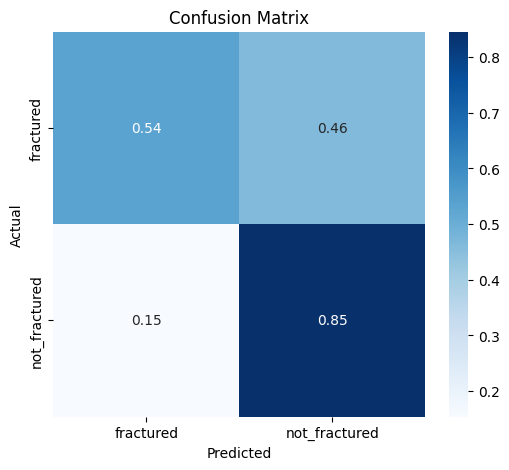


📊 Final MobileNetV2 Summary:

 SL. No.  Sample Size  Train Dataset  Test Dataset        Proposed Model    Input Size  Hidden Layer Size Neurons in Hidden Layers Activation (Hidden)  Neurons (Output Layer) Activation (Output) Optimizer       Loss Function  Epochs  Learning Rate  Execution Time (ms)  Training Accuracy  Validation Accuracy  Testing Accuracy   Loss  Validation Loss  Precision  Recall  F1-score  Classification Miss Rate  Sensitivity  Specificity  F2-score  Fβ-score (β=0.5)  Positive Predicted Value  Negative Predicted Value  False Positive Ratio  False Negative Ratio  Likelihood Positive Ratio  Likelihood Negative Ratio
       2         9463           7090           600 Custom CNN (27-layer) (224, 224, 3)                  4                      512                relu                       1             sigmoid      Adam binary_crossentropy      15          0.001            655746.49             0.9763               0.8359              0.66 0.0688            0.579     0.72

In [15]:
import os
import cv2
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix, fbeta_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Dense, Flatten,
                                     Dropout, BatchNormalization, Activation, GlobalAveragePooling2D)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input

# ========== STEP 1: Load and preprocess data ==========
DATADIR = "/content/BoneFractureDataset/training"
CATEGORIES = ["fractured", "not_fractured"]
IMG_SIZE = 224

training_data = []
for category in CATEGORIES:
    path = os.path.join(DATADIR, category)
    class_num = CATEGORIES.index(category)
    for img in os.listdir(path):
        try:
            img_array = cv2.imread(os.path.join(path, img))
            new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            training_data.append([new_array, class_num])
        except Exception:
            pass

X = np.array([i[0] for i in training_data]).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
y = np.array([i[1] for i in training_data])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# ========== STEP 2: Define Custom Model ==========
custom_model = Sequential()

# Block 1
custom_model.add(Input(shape=(IMG_SIZE, IMG_SIZE, 3)))
custom_model.add(Conv2D(32, (3, 3), padding='same'))
custom_model.add(BatchNormalization())
custom_model.add(Activation('relu'))
custom_model.add(Conv2D(32, (3, 3), padding='same'))
custom_model.add(BatchNormalization())
custom_model.add(Activation('relu'))
custom_model.add(MaxPooling2D(pool_size=(2, 2)))
custom_model.add(Dropout(0.25))

# Block 2
custom_model.add(Conv2D(64, (3, 3), padding='same'))
custom_model.add(BatchNormalization())
custom_model.add(Activation('relu'))
custom_model.add(Conv2D(64, (3, 3), padding='same'))
custom_model.add(BatchNormalization())
custom_model.add(Activation('relu'))
custom_model.add(MaxPooling2D(pool_size=(2, 2)))
custom_model.add(Dropout(0.3))

# Block 3
custom_model.add(Conv2D(128, (3, 3), padding='same'))
custom_model.add(BatchNormalization())
custom_model.add(Activation('relu'))
custom_model.add(Conv2D(128, (3, 3), padding='same'))
custom_model.add(BatchNormalization())
custom_model.add(Activation('relu'))
custom_model.add(MaxPooling2D(pool_size=(2, 2)))
custom_model.add(Dropout(0.4))

# Block 4
custom_model.add(Conv2D(256, (3, 3), padding='same'))
custom_model.add(BatchNormalization())
custom_model.add(Activation('relu'))
custom_model.add(Conv2D(256, (3, 3), padding='same'))
custom_model.add(BatchNormalization())
custom_model.add(Activation('relu'))
custom_model.add(MaxPooling2D(pool_size=(2, 2)))
custom_model.add(Dropout(0.4))

# Final layers
custom_model.add(GlobalAveragePooling2D())
custom_model.add(Dense(512, activation='relu'))
custom_model.add(Dropout(0.5))
custom_model.add(Dense(1, activation='sigmoid'))

# Compile model
custom_model.compile(optimizer=Adam(learning_rate=0.001),
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

# ========== STEP 3: Train Model ==========
start_train_time = time.time()
history = custom_model.fit(X_train, y_train, epochs=15, validation_data=(X_val, y_val))
exec_time = (time.time() - start_train_time) * 1000

# ========== STEP 4: Load Test Data ==========
TEST_DIR = "/content/BoneFractureDataset/testing"
test_data = []
for category in CATEGORIES:
    path = os.path.join(TEST_DIR, category)
    class_num = CATEGORIES.index(category)
    for img in os.listdir(path):
        try:
            img_array = cv2.imread(os.path.join(path, img))
            new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            test_data.append([new_array, class_num])
        except Exception:
            pass

X_test = np.array([i[0] for i in test_data])
y_test = np.array([i[1] for i in test_data])

# ========== STEP 5: Evaluate and Generate Report ==========
loss, test_acc = custom_model.evaluate(X_test, y_test)
y_pred_prob = custom_model.predict(X_test).ravel()
predictions = (y_pred_prob > 0.5).astype("int32")

report = classification_report(y_test, predictions, output_dict=True)
cf_matrix = confusion_matrix(y_test, predictions)
cf_norm = confusion_matrix(y_test, predictions, normalize='true')

cf_matrix = confusion_matrix(y_test, predictions)
cf_norm = confusion_matrix(y_test, predictions, normalize='true')

plt.figure(figsize=(6, 5))
sns.heatmap(cf_norm, annot=True, cmap='Blues', xticklabels=CATEGORIES, yticklabels=CATEGORIES)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ========== STEP 8: Metrics & Summary Table ==========
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
val_loss = history.history['val_loss'][-1]
train_loss = history.history['loss'][-1]

report = classification_report(y_test, predictions, output_dict=True)
precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']
f1 = report['weighted avg']['f1-score']
sensitivity = recall
specificity = np.mean(np.diag(cf_norm))
classification_miss_rate = 1 - test_acc

TP = np.diag(cf_matrix)
FP = np.sum(cf_matrix, axis=0) - TP
FN = np.sum(cf_matrix, axis=1) - TP
TN = np.sum(cf_matrix) - (TP + FP + FN)

PPV = TP / (TP + FP + 1e-10)
NPV = TN / (TN + FN + 1e-10)
FPR = FP / (FP + TN + 1e-10)
FNR = FN / (FN + TP + 1e-10)
LPR = PPV / (1 - FPR + 1e-10)
LNR = FNR / (1 - NPV + 1e-10)

PPV_avg = np.mean(PPV)
NPV_avg = np.mean(NPV)
FPR_avg = np.mean(FPR)
FNR_avg = np.mean(FNR)
LPR_avg = np.mean(LPR)
LNR_avg = np.mean(LNR)

f2 = fbeta_score(y_test, predictions, beta=2, average='weighted')
fbeta_custom = fbeta_score(y_test, predictions, beta=0.5, average='weighted')

# ========== STEP 9: Result Table ==========
result = {
    "SL. No.": 2,
    "Sample Size": len(X) + len(X_test),
    "Train Dataset": len(X_train),
    "Test Dataset": len(X_test),
    "Proposed Model": "Custom CNN (27-layer)",
    "Input Size": X_train.shape[1:4],
    "Hidden Layer Size": 4,
    "Neurons in Hidden Layers": "512",
    "Activation (Hidden)": "relu",
    "Neurons (Output Layer)": 1,
    "Activation (Output)": "sigmoid",
    "Optimizer": "Adam",
    "Loss Function": "binary_crossentropy",
    "Epochs": 15,
    "Learning Rate": 0.001,
    "Execution Time (ms)": round(exec_time, 2),
    "Training Accuracy": round(train_acc, 4),
    "Validation Accuracy": round(val_acc, 4),
    "Testing Accuracy": round(test_acc, 4),
    "Loss": round(train_loss, 4),
    "Validation Loss": round(val_loss, 4),
    "Precision": round(precision, 4),
    "Recall": round(recall, 4),
    "F1-score": round(f1, 4),
    "Classification Miss Rate": round(classification_miss_rate, 4),
    "Sensitivity": round(sensitivity, 4),
    "Specificity": round(specificity, 4),
    "F2-score": round(f2, 4),
    "Fβ-score (β=0.5)": round(fbeta_custom, 4),
    "Positive Predicted Value": round(PPV_avg, 4),
    "Negative Predicted Value": round(NPV_avg, 4),
    "False Positive Ratio": round(FPR_avg, 4),
    "False Negative Ratio": round(FNR_avg, 4),
    "Likelihood Positive Ratio": round(LPR_avg, 4),
    "Likelihood Negative Ratio": round(LNR_avg, 4),
}

df_result = pd.DataFrame([result])
print("\n📊 Final MobileNetV2 Summary:\n")
print(df_result.to_string(index=False))

Epoch 1/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 58s 200ms/step - accuracy: 0.5567 - loss: 0.6960 - val_accuracy: 0.5037 - val_loss: 1.8288
Epoch 2/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 65s 156ms/step - accuracy: 0.6660 - loss: 0.5851 - val_accuracy: 0.5054 - val_loss: 12.8256
Epoch 3/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 41s 157ms/step - accuracy: 0.7095 - loss: 0.5408 - val_accuracy: 0.5353 - val_loss: 2.2789
Epoch 4/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 41s 157ms/step - accuracy: 0.7660 - loss: 0.4751 - val_accuracy: 0.5967 - val_loss: 1.6800
Epoch 5/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 41s 157ms/step - accuracy: 0.8168 - loss: 0.4063 - val_accuracy: 0.5922 - val_loss: 1.1584
Epoch 6/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 41s 156ms/step - accuracy: 0.8475 - loss: 0.3442 - val_accuracy: 0.7124 - val_loss: 0.6713
Epoch 7/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 41s 156ms/step - accuracy: 0.8753 - loss: 0.2924 - val_accuracy: 0.7676 - val_loss: 0.6052
Epoch 8/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 41s 158ms/step - accuracy: 0.8931 - loss: 

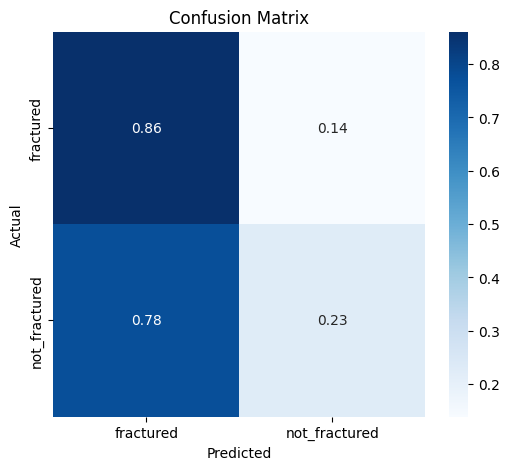


📊 Final MobileNetV2 Summary:

 SL. No.  Sample Size  Train Dataset  Test Dataset        Proposed Model    Input Size  Hidden Layer Size Neurons in Hidden Layers Activation (Hidden)  Neurons (Output Layer) Activation (Output) Optimizer       Loss Function  Epochs  Learning Rate  Execution Time (ms)  Training Accuracy  Validation Accuracy  Testing Accuracy   Loss  Validation Loss  Precision  Recall  F1-score  Classification Miss Rate  Sensitivity  Specificity  F2-score  Fβ-score (β=0.5)  Positive Predicted Value  Negative Predicted Value  False Positive Ratio  False Negative Ratio  Likelihood Positive Ratio  Likelihood Negative Ratio
       2         9463           7090           600 Custom CNN (27-layer) (224, 224, 3)                  4                      512                relu                       1             sigmoid      Adam binary_crossentropy      10          0.001             452512.0             0.9238               0.8398            0.6067 0.1916            0.368     0.58

In [16]:
import os
import cv2
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix, fbeta_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Dense, Flatten,
                                     Dropout, BatchNormalization, Activation, GlobalAveragePooling2D)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input

# ========== STEP 1: Load and preprocess data ==========
DATADIR = "/content/BoneFractureDataset/training"
CATEGORIES = ["fractured", "not_fractured"]
IMG_SIZE = 224

training_data = []
for category in CATEGORIES:
    path = os.path.join(DATADIR, category)
    class_num = CATEGORIES.index(category)
    for img in os.listdir(path):
        try:
            img_array = cv2.imread(os.path.join(path, img))
            new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            training_data.append([new_array, class_num])
        except Exception:
            pass

X = np.array([i[0] for i in training_data]).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
y = np.array([i[1] for i in training_data])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# ========== STEP 2: Define Custom Model ==========
custom_model = Sequential()

# Block 1
custom_model.add(Input(shape=(IMG_SIZE, IMG_SIZE, 3)))
custom_model.add(Conv2D(32, (3, 3), padding='same'))
custom_model.add(BatchNormalization())
custom_model.add(Activation('relu'))
custom_model.add(Conv2D(32, (3, 3), padding='same'))
custom_model.add(BatchNormalization())
custom_model.add(Activation('relu'))
custom_model.add(MaxPooling2D(pool_size=(2, 2)))
custom_model.add(Dropout(0.25))

# Block 2
custom_model.add(Conv2D(64, (3, 3), padding='same'))
custom_model.add(BatchNormalization())
custom_model.add(Activation('relu'))
custom_model.add(Conv2D(64, (3, 3), padding='same'))
custom_model.add(BatchNormalization())
custom_model.add(Activation('relu'))
custom_model.add(MaxPooling2D(pool_size=(2, 2)))
custom_model.add(Dropout(0.3))

# Block 3
custom_model.add(Conv2D(128, (3, 3), padding='same'))
custom_model.add(BatchNormalization())
custom_model.add(Activation('relu'))
custom_model.add(Conv2D(128, (3, 3), padding='same'))
custom_model.add(BatchNormalization())
custom_model.add(Activation('relu'))
custom_model.add(MaxPooling2D(pool_size=(2, 2)))
custom_model.add(Dropout(0.4))

# Block 4
custom_model.add(Conv2D(256, (3, 3), padding='same'))
custom_model.add(BatchNormalization())
custom_model.add(Activation('relu'))
custom_model.add(Conv2D(256, (3, 3), padding='same'))
custom_model.add(BatchNormalization())
custom_model.add(Activation('relu'))
custom_model.add(MaxPooling2D(pool_size=(2, 2)))
custom_model.add(Dropout(0.4))

# Final layers
custom_model.add(GlobalAveragePooling2D())
custom_model.add(Dense(512, activation='relu'))
custom_model.add(Dropout(0.5))
custom_model.add(Dense(1, activation='sigmoid'))

# Compile model
custom_model.compile(optimizer=Adam(learning_rate=0.001),
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

# ========== STEP 3: Train Model ==========
start_train_time = time.time()
history = custom_model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))
exec_time = (time.time() - start_train_time) * 1000

# ========== STEP 4: Load Test Data ==========
TEST_DIR = "/content/BoneFractureDataset/testing"
test_data = []
for category in CATEGORIES:
    path = os.path.join(TEST_DIR, category)
    class_num = CATEGORIES.index(category)
    for img in os.listdir(path):
        try:
            img_array = cv2.imread(os.path.join(path, img))
            new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            test_data.append([new_array, class_num])
        except Exception:
            pass

X_test = np.array([i[0] for i in test_data])
y_test = np.array([i[1] for i in test_data])

# ========== STEP 5: Evaluate and Generate Report ==========
loss, test_acc = custom_model.evaluate(X_test, y_test)
y_pred_prob = custom_model.predict(X_test).ravel()
predictions = (y_pred_prob > 0.5).astype("int32")

report = classification_report(y_test, predictions, output_dict=True)
cf_matrix = confusion_matrix(y_test, predictions)
cf_norm = confusion_matrix(y_test, predictions, normalize='true')

cf_matrix = confusion_matrix(y_test, predictions)
cf_norm = confusion_matrix(y_test, predictions, normalize='true')

plt.figure(figsize=(6, 5))
sns.heatmap(cf_norm, annot=True, cmap='Blues', xticklabels=CATEGORIES, yticklabels=CATEGORIES)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ========== STEP 8: Metrics & Summary Table ==========
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
val_loss = history.history['val_loss'][-1]
train_loss = history.history['loss'][-1]

report = classification_report(y_test, predictions, output_dict=True)
precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']
f1 = report['weighted avg']['f1-score']
sensitivity = recall
specificity = np.mean(np.diag(cf_norm))
classification_miss_rate = 1 - test_acc

TP = np.diag(cf_matrix)
FP = np.sum(cf_matrix, axis=0) - TP
FN = np.sum(cf_matrix, axis=1) - TP
TN = np.sum(cf_matrix) - (TP + FP + FN)

PPV = TP / (TP + FP + 1e-10)
NPV = TN / (TN + FN + 1e-10)
FPR = FP / (FP + TN + 1e-10)
FNR = FN / (FN + TP + 1e-10)
LPR = PPV / (1 - FPR + 1e-10)
LNR = FNR / (1 - NPV + 1e-10)

PPV_avg = np.mean(PPV)
NPV_avg = np.mean(NPV)
FPR_avg = np.mean(FPR)
FNR_avg = np.mean(FNR)
LPR_avg = np.mean(LPR)
LNR_avg = np.mean(LNR)

f2 = fbeta_score(y_test, predictions, beta=2, average='weighted')
fbeta_custom = fbeta_score(y_test, predictions, beta=0.5, average='weighted')

# ========== STEP 9: Result Table ==========
result = {
    "SL. No.": 2,
    "Sample Size": len(X) + len(X_test),
    "Train Dataset": len(X_train),
    "Test Dataset": len(X_test),
    "Proposed Model": "Custom CNN (27-layer)",
    "Input Size": X_train.shape[1:4],
    "Hidden Layer Size": 4,
    "Neurons in Hidden Layers": "512",
    "Activation (Hidden)": "relu",
    "Neurons (Output Layer)": 1,
    "Activation (Output)": "sigmoid",
    "Optimizer": "Adam",
    "Loss Function": "binary_crossentropy",
    "Epochs": 10,
    "Learning Rate": 0.001,
    "Execution Time (ms)": round(exec_time, 2),
    "Training Accuracy": round(train_acc, 4),
    "Validation Accuracy": round(val_acc, 4),
    "Testing Accuracy": round(test_acc, 4),
    "Loss": round(train_loss, 4),
    "Validation Loss": round(val_loss, 4),
    "Precision": round(precision, 4),
    "Recall": round(recall, 4),
    "F1-score": round(f1, 4),
    "Classification Miss Rate": round(classification_miss_rate, 4),
    "Sensitivity": round(sensitivity, 4),
    "Specificity": round(specificity, 4),
    "F2-score": round(f2, 4),
    "Fβ-score (β=0.5)": round(fbeta_custom, 4),
    "Positive Predicted Value": round(PPV_avg, 4),
    "Negative Predicted Value": round(NPV_avg, 4),
    "False Positive Ratio": round(FPR_avg, 4),
    "False Negative Ratio": round(FNR_avg, 4),
    "Likelihood Positive Ratio": round(LPR_avg, 4),
    "Likelihood Negative Ratio": round(LNR_avg, 4),
}

df_result = pd.DataFrame([result])
print("\n📊 Final MobileNetV2 Summary:\n")
print(df_result.to_string(index=False))

Epoch 1/5
222/222 ━━━━━━━━━━━━━━━━━━━━ 67s 205ms/step - accuracy: 0.5127 - loss: 0.8706 - val_accuracy: 0.5054 - val_loss: 0.9017
Epoch 2/5
222/222 ━━━━━━━━━━━━━━━━━━━━ 35s 156ms/step - accuracy: 0.5684 - loss: 0.6749 - val_accuracy: 0.4924 - val_loss: 0.7226
Epoch 3/5
222/222 ━━━━━━━━━━━━━━━━━━━━ 34s 155ms/step - accuracy: 0.6051 - loss: 0.6486 - val_accuracy: 0.5155 - val_loss: 0.6935
Epoch 4/5
222/222 ━━━━━━━━━━━━━━━━━━━━ 41s 157ms/step - accuracy: 0.6121 - loss: 0.6438 - val_accuracy: 0.5279 - val_loss: 0.6837
Epoch 5/5
222/222 ━━━━━━━━━━━━━━━━━━━━ 40s 155ms/step - accuracy: 0.5946 - loss: 0.6396 - val_accuracy: 0.5843 - val_loss: 0.6437
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.8106 - loss: 0.7882
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step


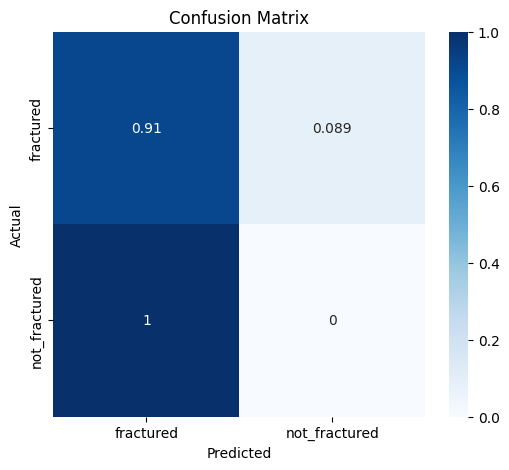


📊 Final Customized model Summary:

 SL. No.  Sample Size  Train Dataset  Test Dataset        Proposed Model    Input Size  Hidden Layer Size Neurons in Hidden Layers Activation (Hidden)  Neurons (Output Layer) Activation (Output) Optimizer       Loss Function  Epochs  Learning Rate  Execution Time (ms)  Training Accuracy  Validation Accuracy  Testing Accuracy   Loss  Validation Loss  Precision  Recall  F1-score  Classification Miss Rate  Sensitivity  Specificity  F2-score  Fβ-score (β=0.5)  Positive Predicted Value  Negative Predicted Value  False Positive Ratio  False Negative Ratio  Likelihood Positive Ratio  Likelihood Negative Ratio
       2         9463           7090           600 Custom CNN (27-layer) (224, 224, 3)                  4                      512                relu                       1             sigmoid      Adam binary_crossentropy       5           0.01            228337.83             0.6124               0.5843            0.5467 0.6364           0.6437    

In [17]:


from sklearn.metrics import classification_report, confusion_matrix, fbeta_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Dense, Flatten,
                                     Dropout, BatchNormalization, Activation, GlobalAveragePooling2D)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input

# ========== STEP 1: Load and preprocess data ==========
DATADIR = "/content/BoneFractureDataset/training"
CATEGORIES = ["fractured", "not_fractured"]
IMG_SIZE = 224

training_data = []
for category in CATEGORIES:
    path = os.path.join(DATADIR, category)
    class_num = CATEGORIES.index(category)
    for img in os.listdir(path):
        try:
            img_array = cv2.imread(os.path.join(path, img))
            new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            training_data.append([new_array, class_num])
        except Exception:
            pass

X = np.array([i[0] for i in training_data]).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
y = np.array([i[1] for i in training_data])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# ========== STEP 2: Define Custom Model ==========
custom_model = Sequential()

# Block 1
custom_model.add(Input(shape=(IMG_SIZE, IMG_SIZE, 3)))
custom_model.add(Conv2D(32, (3, 3), padding='same'))
custom_model.add(BatchNormalization())
custom_model.add(Activation('relu'))
custom_model.add(Conv2D(32, (3, 3), padding='same'))
custom_model.add(BatchNormalization())
custom_model.add(Activation('relu'))
custom_model.add(MaxPooling2D(pool_size=(2, 2)))
custom_model.add(Dropout(0.25))

# Block 2
custom_model.add(Conv2D(64, (3, 3), padding='same'))
custom_model.add(BatchNormalization())
custom_model.add(Activation('relu'))
custom_model.add(Conv2D(64, (3, 3), padding='same'))
custom_model.add(BatchNormalization())
custom_model.add(Activation('relu'))
custom_model.add(MaxPooling2D(pool_size=(2, 2)))
custom_model.add(Dropout(0.3))

# Block 3
custom_model.add(Conv2D(128, (3, 3), padding='same'))
custom_model.add(BatchNormalization())
custom_model.add(Activation('relu'))
custom_model.add(Conv2D(128, (3, 3), padding='same'))
custom_model.add(BatchNormalization())
custom_model.add(Activation('relu'))
custom_model.add(MaxPooling2D(pool_size=(2, 2)))
custom_model.add(Dropout(0.4))

# Block 4
custom_model.add(Conv2D(256, (3, 3), padding='same'))
custom_model.add(BatchNormalization())
custom_model.add(Activation('relu'))
custom_model.add(Conv2D(256, (3, 3), padding='same'))
custom_model.add(BatchNormalization())
custom_model.add(Activation('relu'))
custom_model.add(MaxPooling2D(pool_size=(2, 2)))
custom_model.add(Dropout(0.4))

# Final layers
custom_model.add(GlobalAveragePooling2D())
custom_model.add(Dense(512, activation='relu'))
custom_model.add(Dropout(0.5))
custom_model.add(Dense(1, activation='sigmoid'))

# Compile model
custom_model.compile(optimizer=Adam(learning_rate=0.01),
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

# ========== STEP 3: Train Model ==========
start_train_time = time.time()
history = custom_model.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val))
exec_time = (time.time() - start_train_time) * 1000

# ========== STEP 4: Load Test Data ==========
TEST_DIR = "/content/BoneFractureDataset/testing"
test_data = []
for category in CATEGORIES:
    path = os.path.join(TEST_DIR, category)
    class_num = CATEGORIES.index(category)
    for img in os.listdir(path):
        try:
            img_array = cv2.imread(os.path.join(path, img))
            new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            test_data.append([new_array, class_num])
        except Exception:
            pass

X_test = np.array([i[0] for i in test_data])
y_test = np.array([i[1] for i in test_data])

# ========== STEP 5: Evaluate and Generate Report ==========
loss, test_acc = custom_model.evaluate(X_test, y_test)
y_pred_prob = custom_model.predict(X_test).ravel()
predictions = (y_pred_prob > 0.5).astype("int32")

report = classification_report(y_test, predictions, output_dict=True)
cf_matrix = confusion_matrix(y_test, predictions)
cf_norm = confusion_matrix(y_test, predictions, normalize='true')

cf_matrix = confusion_matrix(y_test, predictions)
cf_norm = confusion_matrix(y_test, predictions, normalize='true')

plt.figure(figsize=(6, 5))
sns.heatmap(cf_norm, annot=True, cmap='Blues', xticklabels=CATEGORIES, yticklabels=CATEGORIES)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ========== STEP 8: Metrics & Summary Table ==========
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
val_loss = history.history['val_loss'][-1]
train_loss = history.history['loss'][-1]

report = classification_report(y_test, predictions, output_dict=True)
precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']
f1 = report['weighted avg']['f1-score']
sensitivity = recall
specificity = np.mean(np.diag(cf_norm))
classification_miss_rate = 1 - test_acc

TP = np.diag(cf_matrix)
FP = np.sum(cf_matrix, axis=0) - TP
FN = np.sum(cf_matrix, axis=1) - TP
TN = np.sum(cf_matrix) - (TP + FP + FN)

PPV = TP / (TP + FP + 1e-10)
NPV = TN / (TN + FN + 1e-10)
FPR = FP / (FP + TN + 1e-10)
FNR = FN / (FN + TP + 1e-10)
LPR = PPV / (1 - FPR + 1e-10)
LNR = FNR / (1 - NPV + 1e-10)

PPV_avg = np.mean(PPV)
NPV_avg = np.mean(NPV)
FPR_avg = np.mean(FPR)
FNR_avg = np.mean(FNR)
LPR_avg = np.mean(LPR)
LNR_avg = np.mean(LNR)

f2 = fbeta_score(y_test, predictions, beta=2, average='weighted')
fbeta_custom = fbeta_score(y_test, predictions, beta=0.5, average='weighted')

# ========== STEP 9: Result Table ==========
result = {
    "SL. No.": 2,
    "Sample Size": len(X) + len(X_test),
    "Train Dataset": len(X_train),
    "Test Dataset": len(X_test),
    "Proposed Model": "Custom CNN (27-layer)",
    "Input Size": X_train.shape[1:4],
    "Hidden Layer Size": 4,
    "Neurons in Hidden Layers": "512",
    "Activation (Hidden)": "relu",
    "Neurons (Output Layer)": 1,
    "Activation (Output)": "sigmoid",
    "Optimizer": "Adam",
    "Loss Function": "binary_crossentropy",
    "Epochs": 5,
    "Learning Rate": 0.01,
    "Execution Time (ms)": round(exec_time, 2),
    "Training Accuracy": round(train_acc, 4),
    "Validation Accuracy": round(val_acc, 4),
    "Testing Accuracy": round(test_acc, 4),
    "Loss": round(train_loss, 4),
    "Validation Loss": round(val_loss, 4),
    "Precision": round(precision, 4),
    "Recall": round(recall, 4),
    "F1-score": round(f1, 4),
    "Classification Miss Rate": round(classification_miss_rate, 4),
    "Sensitivity": round(sensitivity, 4),
    "Specificity": round(specificity, 4),
    "F2-score": round(f2, 4),
    "Fβ-score (β=0.5)": round(fbeta_custom, 4),
    "Positive Predicted Value": round(PPV_avg, 4),
    "Negative Predicted Value": round(NPV_avg, 4),
    "False Positive Ratio": round(FPR_avg, 4),
    "False Negative Ratio": round(FNR_avg, 4),
    "Likelihood Positive Ratio": round(LPR_avg, 4),
    "Likelihood Negative Ratio": round(LNR_avg, 4),
}

df_result = pd.DataFrame([result])
print("\n📊 Final Customized model Summary:\n")
print(df_result.to_string(index=False))

Epoch 1/5
222/222 ━━━━━━━━━━━━━━━━━━━━ 61s 209ms/step - accuracy: 0.5899 - loss: 0.6757 - val_accuracy: 0.5054 - val_loss: 8.7052
Epoch 2/5
222/222 ━━━━━━━━━━━━━━━━━━━━ 62s 158ms/step - accuracy: 0.6933 - loss: 0.5620 - val_accuracy: 0.5054 - val_loss: 7.9848
Epoch 3/5
222/222 ━━━━━━━━━━━━━━━━━━━━ 41s 157ms/step - accuracy: 0.7628 - loss: 0.4834 - val_accuracy: 0.5302 - val_loss: 3.2907
Epoch 4/5
222/222 ━━━━━━━━━━━━━━━━━━━━ 35s 157ms/step - accuracy: 0.8180 - loss: 0.3935 - val_accuracy: 0.8353 - val_loss: 0.3505
Epoch 5/5
222/222 ━━━━━━━━━━━━━━━━━━━━ 41s 158ms/step - accuracy: 0.8590 - loss: 0.3180 - val_accuracy: 0.6159 - val_loss: 2.1107
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.9281 - loss: 0.6001
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step


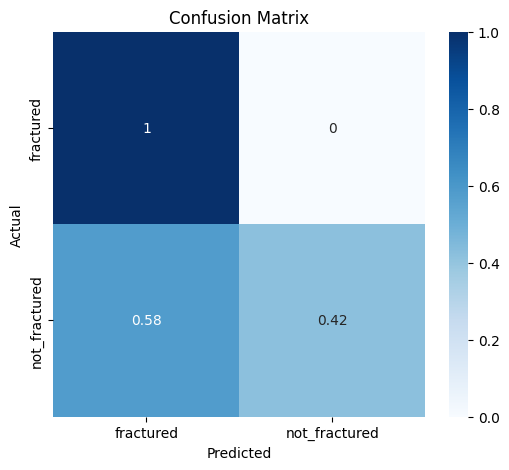


📊 Final Customized model Summary:

 SL. No.  Sample Size  Train Dataset  Test Dataset        Proposed Model    Input Size  Hidden Layer Size Neurons in Hidden Layers Activation (Hidden)  Neurons (Output Layer) Activation (Output) Optimizer       Loss Function  Epochs  Learning Rate  Execution Time (ms)  Training Accuracy  Validation Accuracy  Testing Accuracy   Loss  Validation Loss  Precision  Recall  F1-score  Classification Miss Rate  Sensitivity  Specificity  F2-score  Fβ-score (β=0.5)  Positive Predicted Value  Negative Predicted Value  False Positive Ratio  False Negative Ratio  Likelihood Positive Ratio  Likelihood Negative Ratio
       2         9463           7090           600 Custom CNN (27-layer) (224, 224, 3)                  4                      512                relu                       1             sigmoid      Adam binary_crossentropy       5          0.001            250058.69             0.8656               0.6159            0.7683 0.3038           2.1107    

In [19]:
from sklearn.metrics import classification_report, confusion_matrix, fbeta_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Dense, Flatten,
                                     Dropout, BatchNormalization, Activation, GlobalAveragePooling2D)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input
from tensorflow.keras.models import load_model


# ========== STEP 1: Load and preprocess data ==========
DATADIR = "/content/BoneFractureDataset/training"
CATEGORIES = ["fractured", "not_fractured"]
IMG_SIZE = 224

training_data = []
for category in CATEGORIES:
    path = os.path.join(DATADIR, category)
    class_num = CATEGORIES.index(category)
    for img in os.listdir(path):
        try:
            img_array = cv2.imread(os.path.join(path, img))
            new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            training_data.append([new_array, class_num])
        except Exception:
            pass

X = np.array([i[0] for i in training_data]).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
y = np.array([i[1] for i in training_data])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# ========== STEP 2: Define Custom Model ==========
custom_model = Sequential()

# Block 1
custom_model.add(Input(shape=(IMG_SIZE, IMG_SIZE, 3)))
custom_model.add(Conv2D(32, (3, 3), padding='same'))
custom_model.add(BatchNormalization())
custom_model.add(Activation('relu'))
custom_model.add(Conv2D(32, (3, 3), padding='same'))
custom_model.add(BatchNormalization())
custom_model.add(Activation('relu'))
custom_model.add(MaxPooling2D(pool_size=(2, 2)))
custom_model.add(Dropout(0.25))

# Block 2
custom_model.add(Conv2D(64, (3, 3), padding='same'))
custom_model.add(BatchNormalization())
custom_model.add(Activation('relu'))
custom_model.add(Conv2D(64, (3, 3), padding='same'))
custom_model.add(BatchNormalization())
custom_model.add(Activation('relu'))
custom_model.add(MaxPooling2D(pool_size=(2, 2)))
custom_model.add(Dropout(0.3))

# Block 3
custom_model.add(Conv2D(128, (3, 3), padding='same'))
custom_model.add(BatchNormalization())
custom_model.add(Activation('relu'))
custom_model.add(Conv2D(128, (3, 3), padding='same'))
custom_model.add(BatchNormalization())
custom_model.add(Activation('relu'))
custom_model.add(MaxPooling2D(pool_size=(2, 2)))
custom_model.add(Dropout(0.4))

# Block 4
custom_model.add(Conv2D(256, (3, 3), padding='same'))
custom_model.add(BatchNormalization())
custom_model.add(Activation('relu'))
custom_model.add(Conv2D(256, (3, 3), padding='same'))
custom_model.add(BatchNormalization())
custom_model.add(Activation('relu'))
custom_model.add(MaxPooling2D(pool_size=(2, 2)))
custom_model.add(Dropout(0.4))

# Final layers
custom_model.add(GlobalAveragePooling2D())
custom_model.add(Dense(512, activation='relu'))
custom_model.add(Dropout(0.5))
custom_model.add(Dense(1, activation='sigmoid'))

# Compile model
custom_model.compile(optimizer=Adam(learning_rate=0.001),
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

# ========== STEP 3: Train Model ==========
start_train_time = time.time()
history = custom_model.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val))
exec_time = (time.time() - start_train_time) * 1000

# Save the model after training
custom_model.save("custom_bone_crack_model.keras")

# ========== STEP 4: Load Test Data ==========
TEST_DIR = "/content/BoneFractureDataset/testing"
test_data = []
for category in CATEGORIES:
    path = os.path.join(TEST_DIR, category)
    class_num = CATEGORIES.index(category)
    for img in os.listdir(path):
        try:
            img_array = cv2.imread(os.path.join(path, img))
            new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            test_data.append([new_array, class_num])
        except Exception:
            pass

X_test = np.array([i[0] for i in test_data])
y_test = np.array([i[1] for i in test_data])

# ========== STEP 5: Evaluate and Generate Report ==========
loss, test_acc = custom_model.evaluate(X_test, y_test)
y_pred_prob = custom_model.predict(X_test).ravel()
predictions = (y_pred_prob > 0.5).astype("int32")

report = classification_report(y_test, predictions, output_dict=True)
cf_matrix = confusion_matrix(y_test, predictions)
cf_norm = confusion_matrix(y_test, predictions, normalize='true')

cf_matrix = confusion_matrix(y_test, predictions)
cf_norm = confusion_matrix(y_test, predictions, normalize='true')

plt.figure(figsize=(6, 5))
sns.heatmap(cf_norm, annot=True, cmap='Blues', xticklabels=CATEGORIES, yticklabels=CATEGORIES)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

custom_model = load_model("custom_bone_crack_model.keras")

# ========== STEP 8: Metrics & Summary Table ==========
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
val_loss = history.history['val_loss'][-1]
train_loss = history.history['loss'][-1]

report = classification_report(y_test, predictions, output_dict=True)
precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']
f1 = report['weighted avg']['f1-score']
sensitivity = recall
specificity = np.mean(np.diag(cf_norm))
classification_miss_rate = 1 - test_acc

TP = np.diag(cf_matrix)
FP = np.sum(cf_matrix, axis=0) - TP
FN = np.sum(cf_matrix, axis=1) - TP
TN = np.sum(cf_matrix) - (TP + FP + FN)

PPV = TP / (TP + FP + 1e-10)
NPV = TN / (TN + FN + 1e-10)
FPR = FP / (FP + TN + 1e-10)
FNR = FN / (FN + TP + 1e-10)
LPR = PPV / (1 - FPR + 1e-10)
LNR = FNR / (1 - NPV + 1e-10)

PPV_avg = np.mean(PPV)
NPV_avg = np.mean(NPV)
FPR_avg = np.mean(FPR)
FNR_avg = np.mean(FNR)
LPR_avg = np.mean(LPR)
LNR_avg = np.mean(LNR)

f2 = fbeta_score(y_test, predictions, beta=2, average='weighted')
fbeta_custom = fbeta_score(y_test, predictions, beta=0.5, average='weighted')

# ========== STEP 9: Result Table ==========
result = {
    "SL. No.": 2,
    "Sample Size": len(X) + len(X_test),
    "Train Dataset": len(X_train),
    "Test Dataset": len(X_test),
    "Proposed Model": "Custom CNN (27-layer)",
    "Input Size": X_train.shape[1:4],
    "Hidden Layer Size": 4,
    "Neurons in Hidden Layers": "512",
    "Activation (Hidden)": "relu",
    "Neurons (Output Layer)": 1,
    "Activation (Output)": "sigmoid",
    "Optimizer": "Adam",
    "Loss Function": "binary_crossentropy",
    "Epochs": 5,
    "Learning Rate": 0.001,
    "Execution Time (ms)": round(exec_time, 2),
    "Training Accuracy": round(train_acc, 4),
    "Validation Accuracy": round(val_acc, 4),
    "Testing Accuracy": round(test_acc, 4),
    "Loss": round(train_loss, 4),
    "Validation Loss": round(val_loss, 4),
    "Precision": round(precision, 4),
    "Recall": round(recall, 4),
    "F1-score": round(f1, 4),
    "Classification Miss Rate": round(classification_miss_rate, 4),
    "Sensitivity": round(sensitivity, 4),
    "Specificity": round(specificity, 4),
    "F2-score": round(f2, 4),
    "Fβ-score (β=0.5)": round(fbeta_custom, 4),
    "Positive Predicted Value": round(PPV_avg, 4),
    "Negative Predicted Value": round(NPV_avg, 4),
    "False Positive Ratio": round(FPR_avg, 4),
    "False Negative Ratio": round(FNR_avg, 4),
    "Likelihood Positive Ratio": round(LPR_avg, 4),
    "Likelihood Negative Ratio": round(LNR_avg, 4),
}

df_result = pd.DataFrame([result])
print("\n📊 Final Customized model Summary:\n")
print(df_result.to_string(index=False))

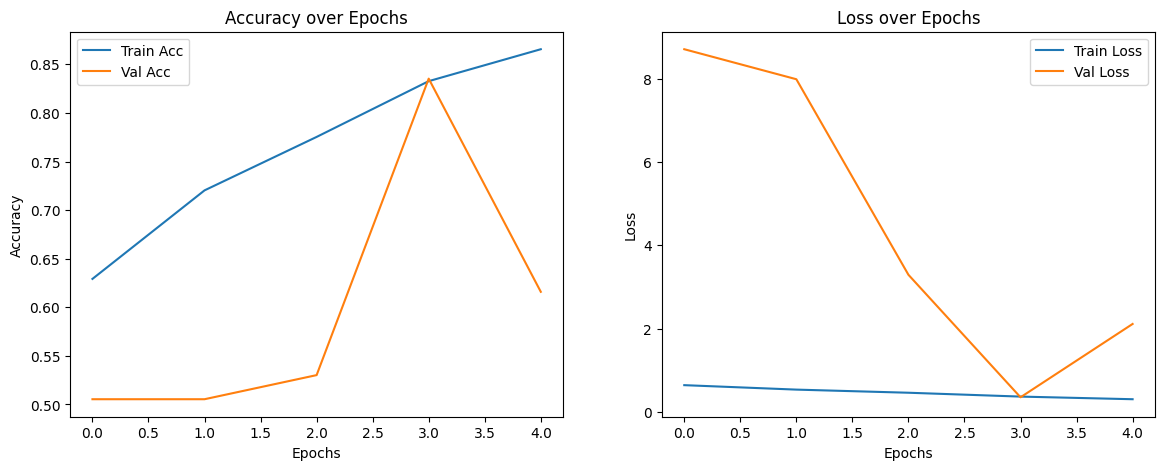

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step


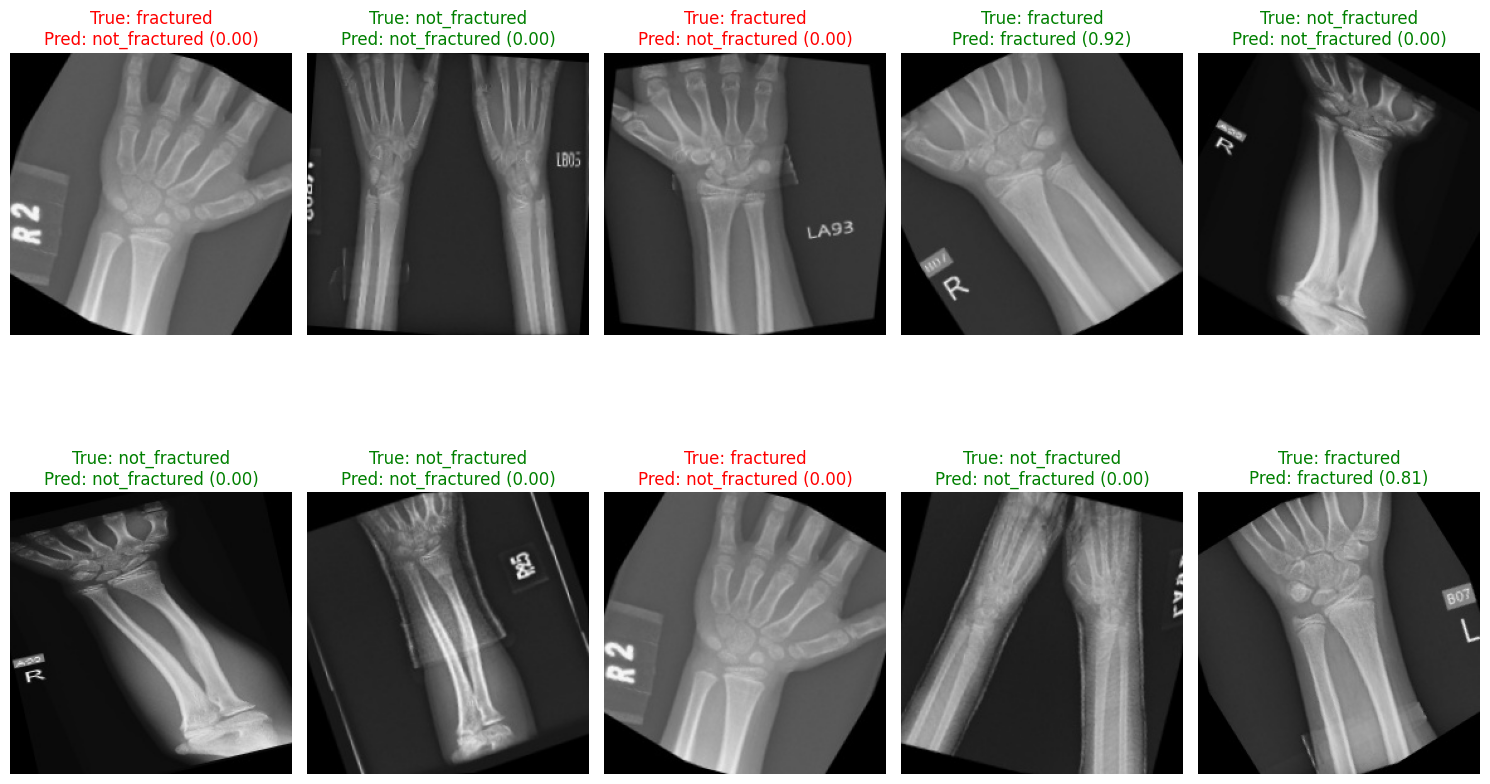

In [22]:
import random

# Map class index to label
class_labels = {0: "not_fractured", 1: "fractured"}

# Predict probabilities
y_probs = custom_model.predict(X_test)
y_preds = (y_probs > 0.5).astype("int32").flatten()

# Show 10 random test images with predictions
plt.figure(figsize=(15, 10))

for i in range(10):
    idx = random.randint(0, len(X_test) - 1)
    img = X_test[idx]
    true_label = class_labels[y_test[idx]]
    predicted_label = class_labels[y_preds[idx]]
    prob = y_probs[idx][0]

    plt.subplot(2, 5, i + 1)
    plt.imshow(img.astype("uint8"))
    plt.title(f"True: {true_label}\nPred: {predicted_label} ({prob:.2f})",
              color="green" if true_label == predicted_label else "red")
    plt.axis('off')

plt.tight_layout()
plt.show()


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step

❌ Total wrong predictions: 139


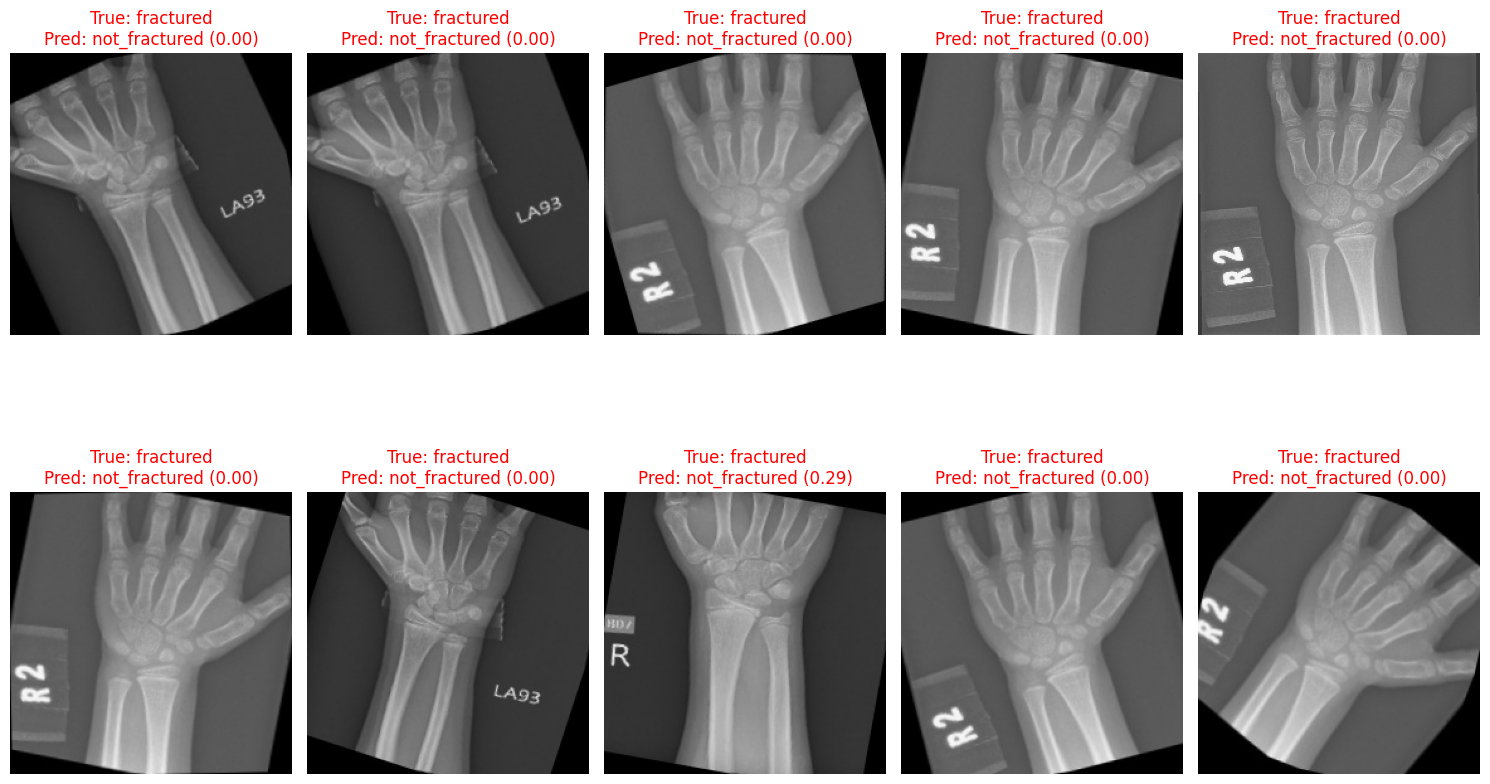

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Predict on test data
y_probs = custom_model.predict(X_test)
y_preds = (y_probs > 0.5).astype("int32").flatten()

# Define label mapping
class_labels = {0: "not_fractured", 1: "fractured"}

# Find indices of incorrect predictions
wrong_indices = np.where(y_preds != y_test)[0]

print(f"\n❌ Total wrong predictions: {len(wrong_indices)}")

# Display some wrongly predicted images
plt.figure(figsize=(15, 10))

for i, idx in enumerate(wrong_indices[:10]):  # Show first 10 wrong predictions
    img = X_test[idx]
    true_label = class_labels[y_test[idx]]
    predicted_label = class_labels[y_preds[idx]]
    prob = y_probs[idx][0]

    plt.subplot(2, 5, i + 1)
    plt.imshow(img.astype("uint8"))
    plt.title(f"True: {true_label}\nPred: {predicted_label} ({prob:.2f})", color="red")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [24]:
!pip install streamlit pyngrok --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 102.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 120.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 8.9 MB/s eta 0:00:00


In [25]:
!ngrok config add-authtoken 2x0WPl4Ox8yRtfU8oyoLhmWzGkB_LnepfYj6ctgYCaVLecGv

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [26]:
!ls /content/


BoneFractureDataset	   custom_bone_crack_model.keras  sample_data
bone-fracture-dataset.zip  kaggle.json


In [27]:
# Save corrected app
app_code = """
import streamlit as st
import tensorflow as tf
from PIL import Image
import numpy as np

# Load model
@st.cache_resource
def load_model():
    model = tf.keras.models.load_model('custom_bone_crack_model.keras')
    return model

model = load_model()
CATEGORIES = ['fractured', 'non-fractured']

st.title('🦴 Bone Fracture X-ray Classifier')

uploaded_file = st.file_uploader("Upload a bone X-ray...", type=['jpg', 'jpeg', 'png'])

if uploaded_file is not None:
    image = Image.open(uploaded_file)
    st.image(image, caption='Uploaded Image', use_column_width=True)

    if st.button('Predict'):
        st.write("⏳ Processing...")
        img = image.resize((224, 224)).convert('RGB')  # Ensure 3 channels
        img_array = np.array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)  # Shape: (1, 224, 224, 3)

        prediction = model.predict(img_array)[0][0]
        label = CATEGORIES[int(prediction > 0.5)]
        confidence = prediction if prediction > 0.5 else 1 - prediction

        st.success(f'✅ Prediction: *{label}* with {confidence * 100:.2f}% confidence.')
"""

with open("app.py", "w") as f:
    f.write(app_code)

# Restart Streamlit
!streamlit run app.py &>/content/logs.txt &

# Recreate Ngrok URL
from pyngrok import ngrok
public_url = ngrok.connect(8501)
print("🌐 Streamlit app is live at:", public_url)


🌐 Streamlit app is live at: NgrokTunnel: "https://3e43-34-126-188-249.ngrok-free.app" -> "http://localhost:8501"
